# MI 2 SoSe22: Exercise sheet 3


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Exercise H3.1: Kernel PCA: Toy Data

##### a)

Creates dataset

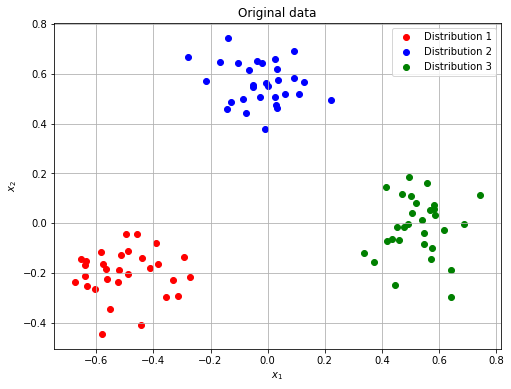

In [2]:
cov_matrix = [[0.01, 0],[0, 0.01]] # Uncorrelated with standard deviation 0.01 (variance 0.01)

# Three different samples with the same covariance matrix but different means
data1 = np.random.multivariate_normal([-.5, -.2], cov_matrix, 30).T
data2 = np.random.multivariate_normal([0, .6], cov_matrix, 30).T
data3 = np.random.multivariate_normal([.5, 0], cov_matrix, 30).T

# Merges data into a 90-dimensional data set
data = np.concatenate((data1, data2, data3), axis = 1).T

plt.figure(figsize=(8,6))
plt.scatter(data1[0], data1[1], marker = 'o', color = 'r', label = "Distribution 1")
plt.scatter(data2[0], data2[1], marker = 'o', color = 'b', label = "Distribution 2")
plt.scatter(data3[0], data3[1], marker = 'o', color = 'g', label = "Distribution 3")
plt.grid()
plt.legend()
plt.title("Original data")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

##### b)

Applies Kernel-PCA with RBF kernel

In [3]:
def RBF(x1, x2, sigma = 0.1):
    ''' Applies RBF kernel to a pair of points.'''
    k_rbf = np.exp(-np.linalg.norm(x1 - x2, 2)**2/(2*sigma**2))
    return k_rbf

def center_kernel(K_uncent):
    ''' Returns centered K from uncentered K'''
    
    rows, columns = K_uncent.shape
    mean_rows = np.repeat(np.mean(K_uncent, axis = 0).reshape(1, columns), rows, axis = 0) 
    mean_columns = np.repeat(np.mean(K_uncent, axis = 1).reshape(rows, 1), columns, axis = 1)
    mean_all = np.mean(K_uncent)
    
    K = K_uncent - mean_rows - mean_columns + mean_all
    return K

In [4]:
# Applying the RBF kernel function to every pair of examples we create the (uncentered) kernel matrix 
K_uncentered = np.zeros((90, 90))

# Fills each entry of the Kernel matrix with the RBF of a pair of examples
for (i, x1) in enumerate(data):
    for (j, x2) in enumerate(data):
        K_uncentered[i,j] = RBF(x1, x2)
        
# Builds the centered Kernel matrix from combinations of the uncentered one
K = center_kernel(K_uncentered)

Now that we created the centered Kernel matrix, we solve the eingenvalue problem 

$$ K \cdot a_k = \lambda_k a_k $$

where $a_k$ correspond to the coefficients of the original PCs in the non-linear basis

$$ e_k = a_k \cdot \Phi(x) $$

Then, we normalize the coefficients so $e_k$ form an orthonormal basis by sending $a_k \rightarrow \frac{a_k}{\sqrt{\lambda_k}}$. We end the process by sorting the eigenvectors and eigenvalues as in standard PCA.

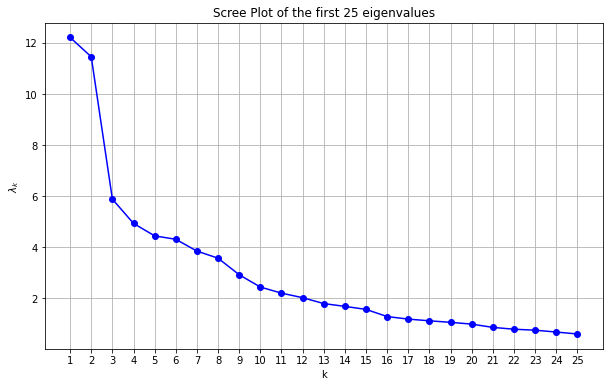

In [5]:
# Gets eigenvalues and eigenvectors
a_value, a_vector = np.linalg.eig(K)

# Normalizes eigenvectors so they correspond to orthonormal original PCs
a_vector_norm = np.zeros((90,90))
for i in range(90):
    a_vector_norm[:, i] = a_vector[:, i]/(np.sqrt(a_value[i]))

# Sorts eigenvalues and eigenvectors
sorted_index = np.argsort(a_value)[::-1] # From highest to lowest
a_value_sorted = a_value[sorted_index]
a_vector_sorted = a_vector_norm[:, sorted_index]

# Scree Plot of the first eigenvalues
n = 25
plt.figure(figsize = (10,6))
plt.plot([i for i in range(1, n+1)], a_value_sorted[:n], 'b-', marker = 'o')
plt.xlabel("k")
plt.ylabel(r"$\lambda_k$")
plt.title(f"Scree Plot of the first {n} eigenvalues")
plt.xticks(range(1, n+1))
plt.grid()
plt.show()

##### c)

Projection into original space

###### i)

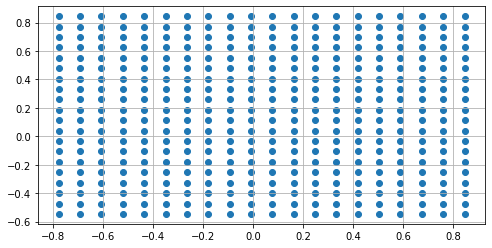

In [6]:
# Creates 2-dimensional grid that covers the original training set
extra = 0.1
x = np.linspace(min(data[:, 0]) - extra, max(data[:, 0]) + extra, 20)
y = np.linspace(min(data[:, 1]) - extra, max(data[:, 0]) + extra, 20)
xx, yy = np.meshgrid(x, y)
grid_points = np.array([xx.flatten(), yy.flatten()])

plt.figure(figsize = (8,4))
plt.scatter(grid_points[0], grid_points[1])
plt.grid()
plt.show()

###### ii)

Now we have to build

$$K_{\beta, x} \equiv k_{\text{RBF}}(x^{(\beta)}, x)$$

for each point in the grid $x$ and center the resulting kernel matrix.

In [7]:
# Now we build the Kernel matrix between examples and test points
K_testpoints_uncentered = np.zeros((90, grid_points.shape[1]))

for (j, x_grid) in enumerate(grid_points.T):
    for (i, x) in enumerate(data):
        K_testpoints_uncentered[i, j] = RBF(x, x_grid)
        
K_testpoints = center_kernel(K_testpoints_uncentered)

Then we create the subspaces spanned by the first 8 PCs so then project into it. To do so, we build the transformed data by using the formula

$$ u_k(x) = \sum_{\beta = 1}^{p} a_k^{(\beta)} K_{\beta, x} $$

for $k=1, \dots, 8$

In [8]:
# Space spanned by the first 8 PCs
a_subspace = a_vector_sorted[:,:8]

data_transformed = a_subspace.T.dot(K_testpoints)

###### iii) & iv)

We project into each of the first 8 PCs together with the original data

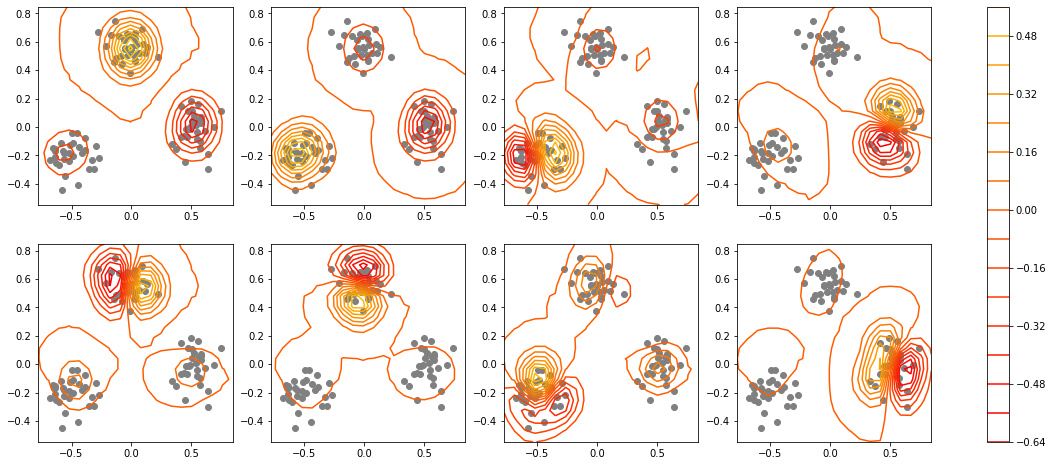

In [9]:
fig, axes = plt.subplots(2,4, figsize = (20,8))

for (i, ax) in enumerate(axes.flatten()):
    pci = data_transformed[i]
    plt.sca(ax)  
    cont = plt.contour(xx, yy, pci.reshape((20,20)), cmap = "hot", vmin = -2, vmax = 2, levels = 15)
    plt.scatter(data[:, 0], data[:, 1], marker = 'o', color = 'grey')

plt.colorbar(cont, ax = axes)
plt.show()